In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from astropy import cosmology
import matplotlib.pyplot as plt
import getdist as gd
from getdist import MCSamples
import getdist.plots as gdplot
import matplotlib
from scipy.stats import norm
import matplotlib.mlab as mlab
from autogalaxy.util import cosmology_util
from astropy import constants


cosmo = cosmology.Planck15

In [2]:
from autoconf import conf
import autofit as af
import autolens as al
import autolens.plot as aplt
from autoarray.structures import arrays
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import matplotlib.pyplot as plt
from matplotlib import gridspec as gridspec
from matplotlib.colors import SymLogNorm
import re
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from autoarray.structures import grids
from autoarray.structures import vector_fields
from autogalaxy import convert
fig_path = '/Users/dgmt59/Documents/Plots/weak_lensing/'


In [3]:
workspace_path = "/Users/dgmt59/PycharmProjects/autolens_slacs/"
output_path = "/Users/dgmt59/output"
aggregator_results_path_1 = output_path + "/slacs_shu_bspline_clean/slacs1430+4105"

fits_header_path = "/Users/dgmt59/Documents/Data/SLACS_headers/SLACSJ1430+4105_F814W_4_biz.fits"

agg = af.Aggregator(directory=str(aggregator_results_path_1), completed_only=True)

Aggregator loading phases... could take some time.

 A total of 8 phases and results were found.


In [4]:
phase_name = "phase[4]_mass[total]_source[fixed]/settings"

agg_shear_sie = agg.filter(agg.directory.contains(phase_name))

print("Total Outputs = ",len(agg_shear_sie))

Filter found a total of 1 results
Total Outputs =  1


In [5]:
data_path = "/Users/dgmt59/Documents/Data/slacs_weak_lensing/1430+4105_F814W_drz_sci_clean.shears"
field_image_path = "/Users/dgmt59/Documents/Data/slacs_weak_lensing/1430+4105_F814W_drz_sci.fits"

weak_shear = fits.open(data_path)

image_shu = fits.open(fits_header_path)[0]

weak_data = weak_shear[1].data

field_image_data  = get_pkg_data_filename(field_image_path)

field_image = fits.getdata(field_image_data, ext=0)
image = fits.open(field_image_data)[0]

In [8]:
print(weak_shear[1].columns.names)

['x', 'y', 'xx', 'yy', 'xy', 'xxxx', 'yyyy', 'xxyy', 'xyyy', 'xxxy', 'prob', 'skymed', 'skysd', 'skysw', 'exp_time', 'radius', 'x_err', 'y_err', 'xx_err', 'yy_err', 'xy_err', 'xxxx_err', 'yyyy_err', 'xxyy_err', 'xyyy_err', 'xxxy_err', 'prob_err', 'skymed_err', 'skysd_err', 'skysw_err', 'exp_time_err', 'ra', 'dec', 'e1', 'e2', 'e1_err', 'e2_err', 'ell', 'pa', 'gal_size', 'a', 'b', 'NUMBER', 'X_IMAGE', 'Y_IMAGE', 'X_WORLD', 'Y_WORLD', 'THETA_WORLD', 'THETA_IMAGE', 'A_IMAGE', 'B_IMAGE', 'FWHM_IMAGE', 'MAG_ISO', 'MU_MAX', 'MAG_AUTO', 'MAGERR_AUTO', 'MAGERR_ISO', 'ISOAREA_IMAGE', 'CLASS_STAR', 'BACKGROUND', 'FLAGS', 'FLUX_AUTO', 'FLUXERR_AUTO', 'KRON_RADIUS', 'RA', 'DEC', 'galStarFlag', 'j9op36bf_X_IMAGE', 'j9op36bf_Y_IMAGE', 'j9op36bg_X_IMAGE', 'j9op36bg_Y_IMAGE', 'j9op36bi_X_IMAGE', 'j9op36bi_Y_IMAGE', 'j9op36bk_X_IMAGE', 'j9op36bk_Y_IMAGE', 'shear', 'nExposures', 'xx_uncorrected', 'yy_uncorrected', 'gamma1', 'gamma2', 'clean']


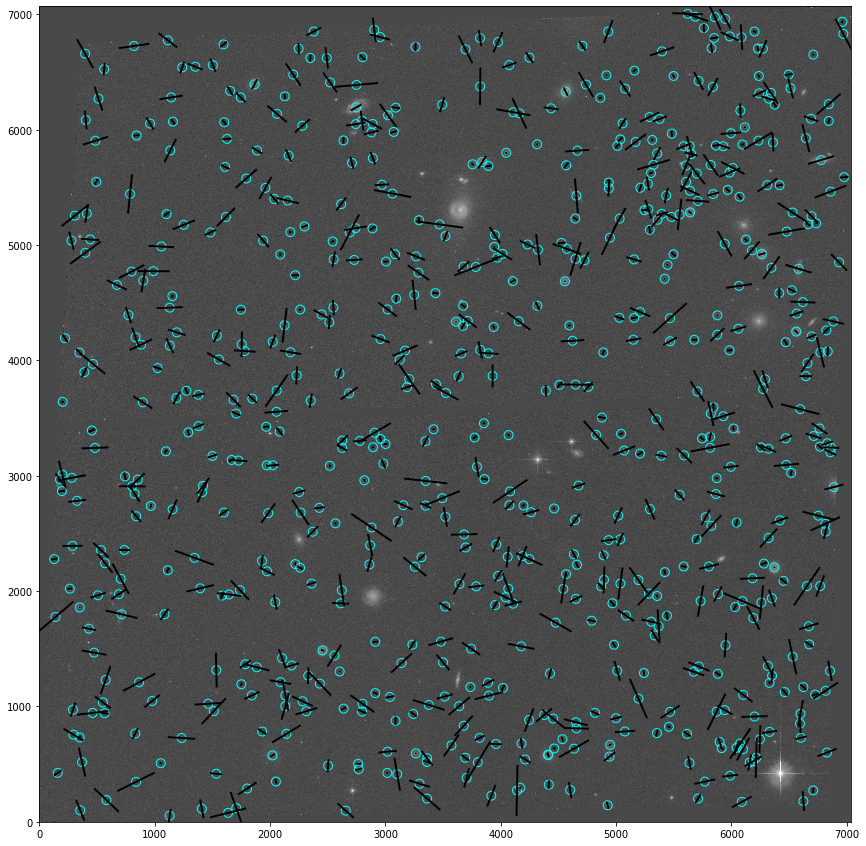

In [7]:
figure = plt.figure(figsize=(15,15))
plt.imshow(field_image,  cmap='gray', norm=SymLogNorm(vmin=-0.13, vmax=20, linthresh=0.02, linscale=1.0))
quiveropts = dict(headlength=0, pivot='middle',
                      linewidth=5., units='xy', angles='xy',
                      headwidth=1, alpha=1., cmap='autumn')
#ax.plot_coord(SkyCoord(lens_centre.ra.deg*u.deg, lens_centre.dec.deg*u.deg), "+")
plt.scatter(weak_data.x, weak_data.y, edgecolors="cyan", marker="o", facecolors='none', s=80)
plt.gca().invert_yaxis()
plt.quiver(weak_data.x,weak_data.y,weak_data.gamma1,weak_data.gamma2, **quiveropts)
#plt.gca().invert_yaxis()
plt.savefig(f"{fig_path}1430+4105.png")
plt.show()


In [65]:
def central_pixel_coordinates_from(shape):
    return tuple([float(dim-1) / 2 for dim in shape])

def central_scaled_coordinates_from(shape, pixel_scales, origins=None):
    if type(pixel_scales) is float:
        pixel_scales = tuple([pixel_scales for i in range(len(shape))])
    if origins is None:
        origins = tuple([0.0 for i in range(len(shape))])
    central_pixel_coordinates = central_pixel_coordinates_from(shape=shape)
    y_pixel = central_pixel_coordinates[0] + (origins[0] / pixel_scales[0])
    x_pixel = central_pixel_coordinates[1] - (origins[1] / pixel_scales[1])
    return (y_pixel, x_pixel)

def pixel_coordinates_from_scaled_coordinates(scaled_coordinates, shape, pixel_scales, origins=None):
    if type(pixel_scales) is float:
        pixel_scales = tuple([pixel_scales for i in range(len(shape))])
    central_pixel_coordinates = central_pixel_coordinates_from(shape=shape)
    y_pixel = int((-scaled_coordinates[0] + origins[0])/pixel_scales[0] + central_pixel_coordinates[0] + 0.5)
    x_pixel = int((scaled_coordinates[1] - origins[1])/pixel_scales[1] + central_pixel_coordinates[1] + 0.5)
    return (y_pixel, x_pixel)

def scaled_coordinates_from_pixel_coordinates(pixel_coordinates, shape, pixel_scales, origins=None):
    if type(pixel_scales) is float:
        pixel_scales = tuple([pixel_scales for i in range(len(shape))])
    central_scaled_coordinates = central_scaled_coordinates_from(shape=shape, pixel_scales=pixel_scales, origins=origins)
    y_pixel = pixel_scales[0] * -(pixel_coordinates[0] - central_scaled_coordinates[0])
    x_pixel = pixel_scales[1] * (pixel_coordinates[1] - central_scaled_coordinates[1])
    return (y_pixel, x_pixel)

def move_origin_to(central_pixel, data):
    new_x = []
    new_y = []
    for i in range(len(data.x)):
        for j in range(len(data.y)):
            new_x.append(data.x[i]-central_pixel[1])
            new_y.append(data.y[j]-central_pixel[0])

    return [new_y, new_x]

def move_origin_in_arcsec_to(centre, x, y):
    new_x = []
    new_y = []
    for i in range(len(x)):
        new_x.append(x[i]-centre[1])
        new_y.append(y[i]-centre[0])

    return np.transpose(np.array([new_y, new_x]))

In [83]:
arcs_sec_x, arc_sec_y = weak_data.x *0.03,weak_data.y*0.03
arc_sec_centred = move_origin_in_arcsec_to(centre=[159.0984, 109.6236], x=arcs_sec_x, y=arc_sec_y)

origin_arc_sec = (scaled_coordinates_from_pixel_coordinates(pixel_coordinates=[5303.28, 7035-3654.12], pixel_scales=0.03, shape=field_image.shape))


In [84]:
#print(pixel_coordinates_from_scaled_coordinates(scaled_coordinates=origin_arc_sec, pixel_scales=0.03, shape=image_shu.shape))

print(origin_arc_sec)

(-53.03339999999999, -4.068599999999996)


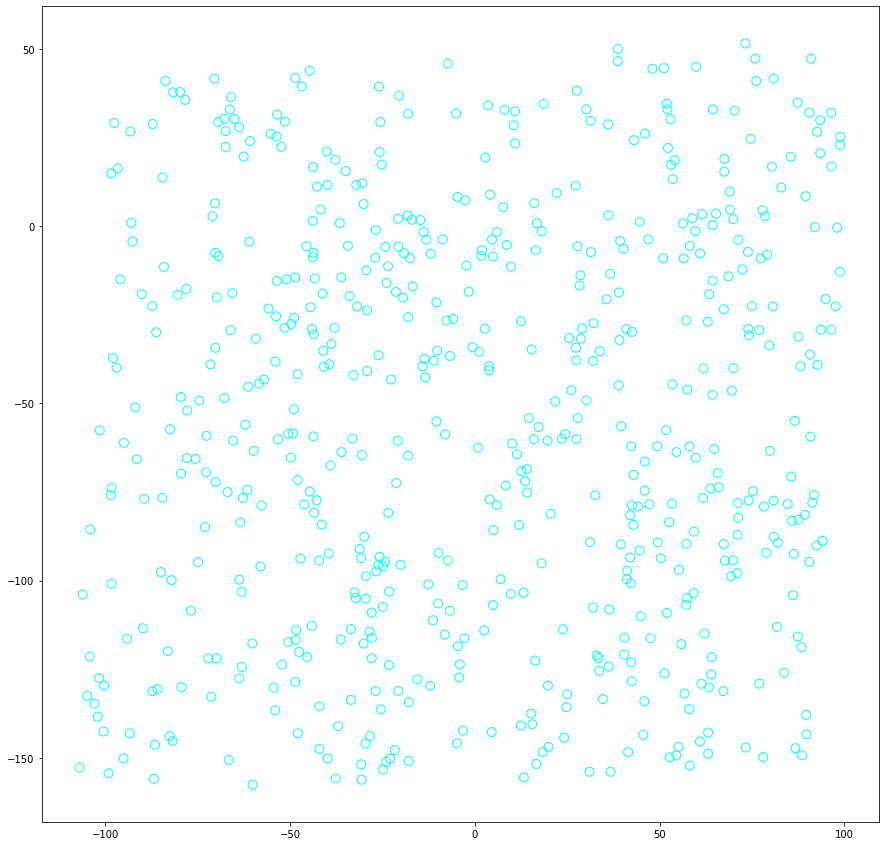

In [68]:
figure = plt.figure(figsize=(15,15))
plt.scatter(arc_sec_centred[:,1], arc_sec_centred[:,0], edgecolors="cyan", marker="o", facecolors='none', s=80)

In [69]:
print(len(arc_sec_centred[:,0]))

603


In [70]:
weak_shear_grid = grids.GridIrregular(grid=arc_sec_centred)
weak_shear_field = vector_fields.VectorFieldIrregular(grid=weak_shear_grid, vectors=np.transpose(np.asarray([weak_data.gamma2, weak_data.gamma1])))

weak_field_inside = weak_shear_field.vectors_within_radius(centre=(0,0), radius=45)


In [71]:
print(weak_field_inside.average_magnitude)
print(weak_field_inside.average_phi)



0.013263500201819366
-17.269553259267035


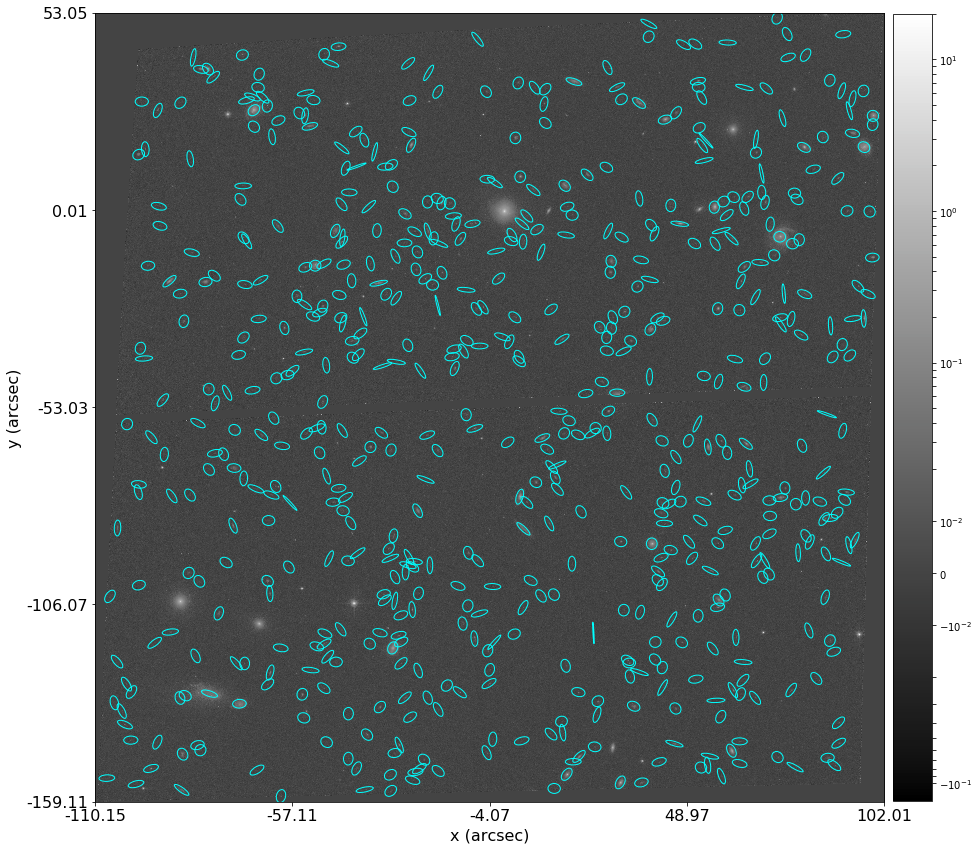

In [89]:
imaging = al.Array.from_fits(
    file_path=field_image_path,
    pixel_scales=0.03,
    origin=origin_arc_sec,
)
image_2d = imaging.in_2d


plotter = aplt.Plotter(figure=aplt.Figure(figsize=(15,15)),cmap=aplt.ColorMap(cmap="gray", norm="symmetric_log", norm_min=-0.13, norm_max=20, linthresh=0.02, linscale=1.0),
                      # output=aplt.Output(path=fig_path, filename='shears_included', format='png'))
                       )
aplt.Array(array=image_2d, plotter=plotter, patches=weak_shear_field.elliptical_patches)

In [88]:
print('done')

done


In [73]:
datasets_shear = agg_shear_sie.values("dataset")
outputs_shear = agg_shear_sie.values("samples")
info_shear = agg_shear_sie.values("info")
instances_shear = [samps.median_pdf_instance for samps in agg_shear_sie.values("samples")]

for instance, info, dataset in zip(instances_shear, info_shear, datasets_shear):
    lens = dataset.name
    R_Ein = instance.galaxies.lens.mass.einstein_radius
    centre_x = instance.galaxies.lens.mass.centre[1]
    centre_y = instance.galaxies.lens.mass.centre[0]
    axis_ratio = instance.galaxies.lens.mass.axis_ratio
    phi = instance.galaxies.lens.mass.phi-90+image.header["ORIENTAT"]
    z_lens = info["redshift_lens"]

    sie = al.mp.EllipticalIsothermal(
            centre=(centre_y, centre_x),
            einstein_radius=R_Ein,
            elliptical_comps=al.convert.elliptical_comps_from(
                axis_ratio=axis_ratio,
                phi=phi))

In [74]:
strong_shear = sie.shear_from_grid(grid=weak_shear_grid)
weak_shear_sie_subtracted = weak_shear_field-strong_shear

In [75]:
radii = np.arange(7, 46, 1)
print(radii)

shears = []
angles = []
for radius in radii:
    weak_shear_sie_subtracted_inside = weak_shear_sie_subtracted.vectors_within_radius(centre=(0,0), radius=radius)
    shears.append(weak_shear_sie_subtracted_inside.average_magnitude)
    angles.append(weak_shear_sie_subtracted_inside.average_phi)

[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


In [76]:
grid = al.Grid.uniform(shape_2d=(200, 200), pixel_scales=0.05, sub_size=2)
"""From AutoLens"""
sie_test = al.mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.0, elliptical_comps=convert.elliptical_comps_from(axis_ratio=0.6, phi=20))

shear = sie_test.shear_via_jacobian_from_grid(grid=grid)
shear_from_field = sie_test.shear_from_grid(grid=grid)


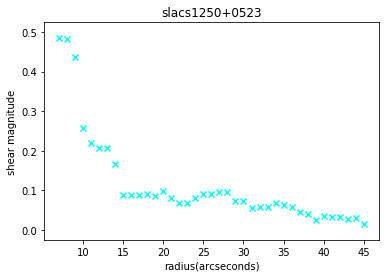

In [77]:
fig = plt.figure()
plt.scatter(radii, shears, color='cyan', marker='x')
plt.xlabel("radius(arcseconds)")
plt.ylabel("shear magnitude")
plt.title("slacs1250+0523")
plt.savefig(fig_path + 'radius_v_mag_1250+0523.png', bbox_inches='tight', dpi=300)

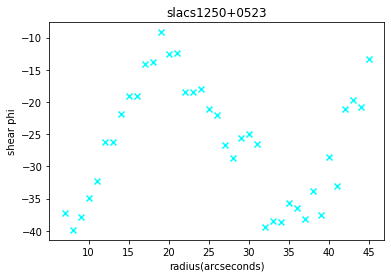

In [78]:
fig = plt.figure()
plt.scatter(radii, angles, color='cyan', marker='x')
plt.xlabel("radius(arcseconds)")
plt.ylabel("shear phi")
plt.title("slacs1250+0523")
plt.savefig(fig_path + 'radius_v_angle_1250+0523.png', bbox_inches='tight', dpi=300)